In [1]:
# Встановлення необхідних бібліотек
import tensorflow as tf
from keras import layers, models
from keras.optimizers.legacy import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import numpy as np

# Завантаження даних
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Перевірка розмірності даних
print(f"Розмірність тренувальних зображень: {train_images.shape}")
print(f"Розмірність тестових зображень: {test_images.shape}")

selected_classes=[5,6,2]# dog / frog / bird
train_mask= np.isin(train_labels.flatten(), selected_classes)
test_mask=np.isin(test_labels.flatten (), selected_classes)

#Відфільтруємо дані
train_images, train_labels = train_images[train_mask],train_labels [train_mask]
test_images, test_labels = test_images[test_mask], test_labels[test_mask]

#we are doing normalization
train_images, test_images=train_images/255.0, test_images/255.0




Розмірність тренувальних зображень: (50000, 32, 32, 3)
Розмірність тестових зображень: (10000, 32, 32, 3)


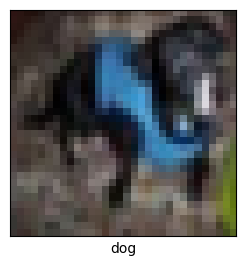

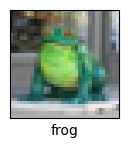

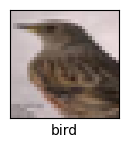

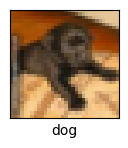

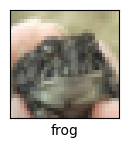

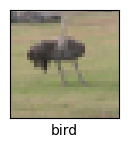

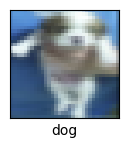

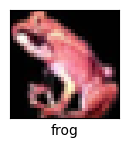

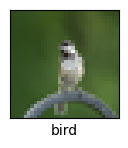

In [17]:
import matplotlib.pyplot as plt

class_names = ['dog', 'frog', 'bird']

#Візуалізація перших 9 зображень
plt.figure(figsize=(10, 10))
class_index = 0
for i in range (9):
    while class_index>= len(class_names):
        class_index = 0 # Починаємо спочатку, якщо всі класи вже відображені 
    current_class = selected_classes[class_index]
    class_images = train_images[train_labels.flatten() == current_class] 
    plt.subplot (3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid (False)
    plt.imshow(class_images[i])
    plt.xlabel(class_names[class_index])
    class_index += 1
    plt.show()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)             

c:\Users\cherrypix\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 9s 17ms/step - loss: 0.8461 - accuracy: 0.6026 - val_loss: 0.7087 - val_accuracy: 0.6990
Epoch 2/10
469/469 [==============================] - 7s 14ms/step - loss: 0.6354 - accuracy: 0.7325 - val_loss: 0.6287 - val_accuracy: 0.7353
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 0.5548 - accuracy: 0.7713 - val_loss: 0.5454 - val_accuracy: 0.7797
Epoch 4/10
469/469 [==============================] - 7s 16ms/step - loss: 0.4924 - accuracy: 0.8021 - val_loss: 0.5040 - val_accuracy: 0.7960
Epoch 5/10
469/469 [==============================] - 7s 14ms/step - loss: 0.4500 - accuracy: 0.8223 - val_loss: 0.4838 - val_accuracy: 0.8070
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.4094 - accuracy: 0.8367 - val_loss: 0.5180 - val_accuracy: 0.7897
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.3712 - accuracy: 0.8542 - val_loss: 0.4696 - val_accuracy: 0.8160
Epoch 8/10

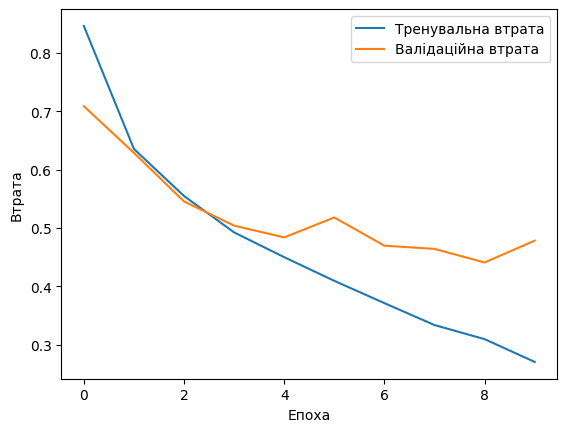

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax'))
model.summary()

#Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy'  , metrics=['accuracy'])
#Перетворення міток
class_mapping={5:0, 6:1, 2:2}

train_labels_mapped = np.vectorize(class_mapping.get) (train_labels)
test_labels_mapped = np.vectorize(class_mapping.get) (test_labels)

checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
# Зупинка тренування, якщо немає поліпшень протягом 5 епох
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

history = model.fit(train_images, train_labels_mapped, epochs=10, validation_data = (test_images, test_labels_mapped),
                    callbacks=[checkpoint, early_stopping])
# Візуалізація процесу тренування
plt.plot(history.history['loss'], label='Тренувальна втрата')
plt.plot(history.history['val_loss'], label='Валідаційна втрата')
plt.xlabel('Епоха')
plt.ylabel('Втрата')
plt.legend()
plt.show()

In [4]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Визначення показників якості
test_loss, test_acc = model.evaluate(test_images, test_labels_mapped, verbose=2)
print(f'\nТочність на тестових даних: {test_acc}')


94/94 - 0s - loss: 0.4783 - accuracy: 0.8227 - 487ms/epoch - 5ms/step

Точність на тестових даних: 0.8226666450500488


94/94 [==============================] - 1s 6ms/step


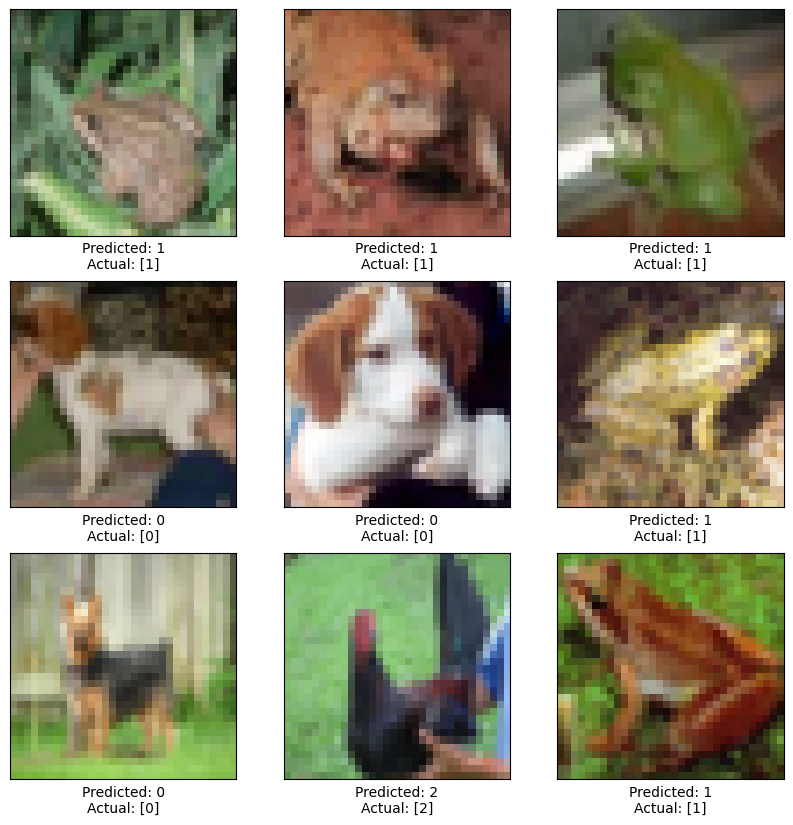

In [23]:
# Отримання передбачень для тестових зображень
predictions = model.predict(test_images)

# Функція для отримання індексу максимального значення у векторі ймовірностей
def get_predicted_class(probabilities):
    return np.argmax(probabilities)

# Візуалізація перших 9 зображень та їх передбачених класів
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Отримання передбаченого та правильного класів для поточного зображення
    predicted_class = get_predicted_class(predictions[i])
    actual_class = test_labels_mapped[i]
    
    # Відображення зображення та передбаченого класу
    plt.imshow(test_images[i])
    plt.xlabel(f'Predicted: {predicted_class}\nActual: {actual_class}')

plt.show()
